In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pickle
import pandas as pd
import numpy as np

In [3]:
with open('word2index.pickle', 'rb') as handle:
    word2index = pickle.load(handle)

In [4]:
word2index

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'investigate': 3,
 'efficacy': 4,
 '6': 5,
 'weeks': 6,
 'daily': 7,
 'lowdose': 8,
 'oral': 9,
 'prednisolone': 10,
 'improving': 11,
 'pain': 12,
 'mobility': 13,
 'systemic': 14,
 'lowgrade': 15,
 'inflammation': 16,
 'short': 17,
 'term': 18,
 'whether': 19,
 'effect': 20,
 'would': 21,
 'sustained': 22,
 '12': 23,
 'older': 24,
 'adults': 25,
 'moderate': 26,
 'severe': 27,
 'knee': 28,
 'osteoarthritis': 29,
 'oa': 30,
 'total': 31,
 '125': 32,
 'patients': 33,
 'primary': 34,
 'randomized': 35,
 '11': 36,
 '63': 37,
 'received': 38,
 '75': 39,
 'mg': 40,
 'day': 41,
 '62': 42,
 'placebo': 43,
 'outcome': 44,
 'measures': 45,
 'included': 46,
 'reduction': 47,
 'improvement': 48,
 'function': 49,
 'scores': 50,
 'markers': 51,
 'assessed': 52,
 'using': 53,
 'visual': 54,
 'analog': 55,
 'scale': 56,
 '0100': 57,
 'mm': 58,
 'secondary': 59,
 'western': 60,
 'ontario': 61,
 'mcmaster': 62,
 'universities': 63,
 'inde': 64,
 'patient': 65,
 

In [5]:
train_df=pd.read_pickle('../data/abstracts_data/20k_abstracts/processed_train.pickle')
test_df=pd.read_pickle('../data/abstracts_data/20k_abstracts/processed_test.pickle')

In [6]:
def label_map(label):
    if label == "RESULTS":
        return 0
    elif label == "METHODS":
        return 1
    elif label == "CONCLUSIONS":
        return 2
    elif label == "BACKGROUND":
        return 3
    else: #positive
        return 4

seq_length = 194
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [7]:
train_set = [(label, tokens) for label, tokens in zip(train_df['target'], train_df['text_tokens'])]
test_set = [(label, tokens) for label, tokens in zip(test_df['target'], test_df['text_tokens'])]

In [8]:
# train_set

In [9]:
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in train_set]
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test_set]

In [10]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [11]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 5)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [12]:
use_cuda = torch.cuda.is_available()
# use_mps = torch.backends.mps.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [13]:
model

BiLSTM_SentimentAnalysis(
  (embedding): Embedding(91942, 64, padding_idx=0)
  (lstm): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

In [11]:
from tqdm.notebook import trange, tqdm

In [12]:
epochs = 1
losses = []
for e in range(epochs):
    
    print('\nEpoch: {}'.format(e))
    
    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch in tqdm(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
#             print(out.shape)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())


Epoch: 0


  0%|          | 0/3600 [00:00<?, ?it/s]

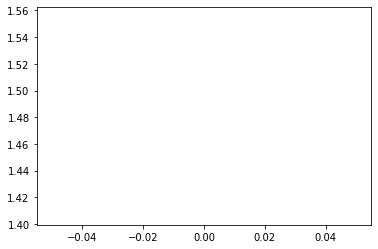

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [19]:
from sklearn.metrics import accuracy_score
import time

batch_acc = []
t0 = time.perf_counter()
for batch_idx, batch in enumerate(test_dl):
    
    input = batch[0].to(device)
    target = batch[1].to(device)

#     optimizer.zero_grad()
    with torch.no_grad():
        out, hidden = model(input, (h0, c0))
#         print(out)
#         print(F.softmax(out))
        preds = torch.argmax(F.softmax(out, dim=1),1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))
time_elapsed = time.perf_counter() - t0
print('Time Elapsed:{}'.format(time_elapsed))

sum(batch_acc)/len(batch_acc)

Time Elapsed:1.5257616452872753


0.32837209302325615

In [15]:
import pandas as pd
df=pd.DataFrame()
df['device']=[torch.cuda.get_device_name(0)]
df['time']=[time_elapsed]
df.to_csv('pt_text_classification_time_elapsed_'+f'{torch.cuda.get_device_name(0)}.csv', index=False)
df

,device,time
0,Tesla V100-SXM2-32GB,1.492147


In [16]:
torch.save(model, './models/pt_text_classification_model_'+f'{torch.cuda.get_device_name(0)}.pth')

## Test Crypten

In [18]:
# !pip install --user crypten

In [20]:
from tqdm.notebook import tqdm
import crypten.mpc as mpc
import crypten.communicator as comm
import crypten

crypten.init()
torch.set_num_threads(1)

/home/ss4yd/.local/lib/python3.8/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [23]:
def get_time_elapsed_crypten(device, test_loader, hidden):
    plaintext_model = torch.load('./models/pt_text_classification_model_'+f'{torch.cuda.get_device_name(0)}.pth').to('cpu')
    dummy_input = input.to('cpu'), (h0.to('cpu'), c0.to('cpu'))

    private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)
    private_model.encrypt(src=0)
    private_model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        t0 = time.perf_counter()
        for data, target in tqdm(test_loader):
            target = target
            data_enc = crypten.cryptensor(data)
            output, hidden = private_model(data_enc, hidden)
            output = output_enc.get_plain_text()
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            preds = torch.argmax(F.softmax(output, dim=1),1)
            correct += pred.eq(target.view_as(pred)).sum().item()
        time_elapsed = time.perf_counter() - t0

    test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    print('Time Elapsed:{}'.format(time_elapsed))
    return time_elapsed

time=get_time_elapsed_crypten( device, test_dl, (h0,c0))



AssertionError: number of outputs should be 1

In [27]:
plaintext_model = torch.load('./models/pt_text_classification_model_'+f'{torch.cuda.get_device_name(0)}.pth').to('cpu')
dummy_input = input.to('cpu'), (h0.to('cpu'), c0.to('cpu'))

private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)
private_model.encrypt(src=0)
private_model.eval()

AssertionError: number of outputs should be 1

In [28]:
plaintext_model

BiLSTM_SentimentAnalysis(
  (embedding): Embedding(91942, 64, padding_idx=0)
  (lstm): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

In [29]:
input

tensor([[    1,  8374,  2816,  ...,     0,     0,     0],
        [    1,   894,   434,  ...,     0,     0,     0],
        [    1,    74,    31,  ...,     0,     0,     0],
        ...,
        [    1,   154,  2981,  ...,     0,     0,     0],
        [    1,    31,  9794,  ...,     0,     0,     0],
        [    1,   463, 34622,  ...,     0,     0,     0]], device='cuda:0')